# ASL Alphabet Classifier Test Series #4 Own Data

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet34 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will be overfitted, however it's a good test of the library.
<br>
<br>
<br>

In [1]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import fastai

# plt.style.use('dark')


In [2]:
# path = '../data/external/Training Set'
path = '../data/frank-combined'

<br>

### Create the DataBlock

In [3]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label)

# learn_inf = load_learner('../models/export-resnet101-tune10un-tune2ft.pkl')



<br>

## Resize and add basic image augmentation

In [4]:
# signs = signs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
signs = signs.new(item_tfms=Resize(384, method=ResizeMethod.Squish))

# signs.apply_tfms(Image.flip)


<br>

### Load the data by path

In [5]:
dls = signs.dataloaders(path, bs=8)


<br>

### Verify the Training and Validation Batches

In [ ]:
dls.train.show_batch(max_n=4, nrows=1)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

<br>

### Define the model (Resnet34) and fit

In [6]:
learn = cnn_learner(dls, resnet101 , metrics=error_rate)

<br>
<br>
<br>

## Manually find a learning rate between the shoulder and the steepest drop.

In [ ]:
lr_min,lr_steep = learn.lr_find()


In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

<br>
<br>

## Fit the last layer, unfreeze, fit the whole net, with a descriminant LR, all in one go.
Model architecture: resnet101 @ 384px <br>
Filename: ../models/200925-0100-RESNET101-384px-FONLY-ft6f4.pkl

In [7]:
learn.fine_tune(3, freeze_epochs=3, base_lr=3e-4, bs=8)

epoch,train_loss,valid_loss,error_rate,time
0,1.219511,3.373195,0.169617,05:42
1,0.505601,3.072994,0.058407,05:42
2,0.190075,2.708431,0.033333,05:42


epoch,train_loss,valid_loss,error_rate,time
0,0.076258,0.244704,0.020059,08:18
1,0.016600,0.009270,0.002065,08:18
2,0.004078,0.004184,0.001180,08:18


<br>
<br>
<br>

## ~~Fit the last layer to our data~~

In [ ]:
#learn.fit_one_cycle(2, 4e-2)

<br>
<br>
<br>

## ~~Unfreeze the rest of the layers and find a new learning rate for the whole net.~~

In [ ]:
#learn.unfreeze()

In [ ]:
#learn.lr_find()

<br>
<br>
<br>

## ~~Fit the whole network at an appropriate learning rate~~

In [ ]:
#learn.fit_one_cycle(2, lr_max=5e-5)

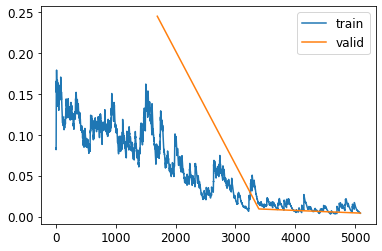

In [9]:
learn.recorder.plot_loss()

<br>

### Visualize with a confusion Matrix

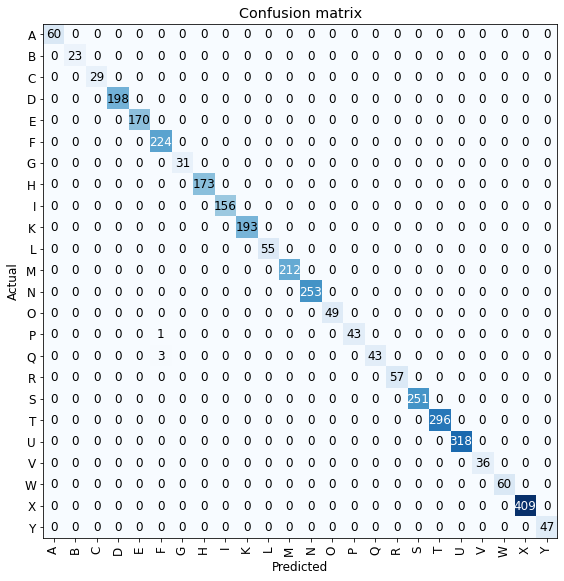

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

<br>

### Show the top 5 most error prone images

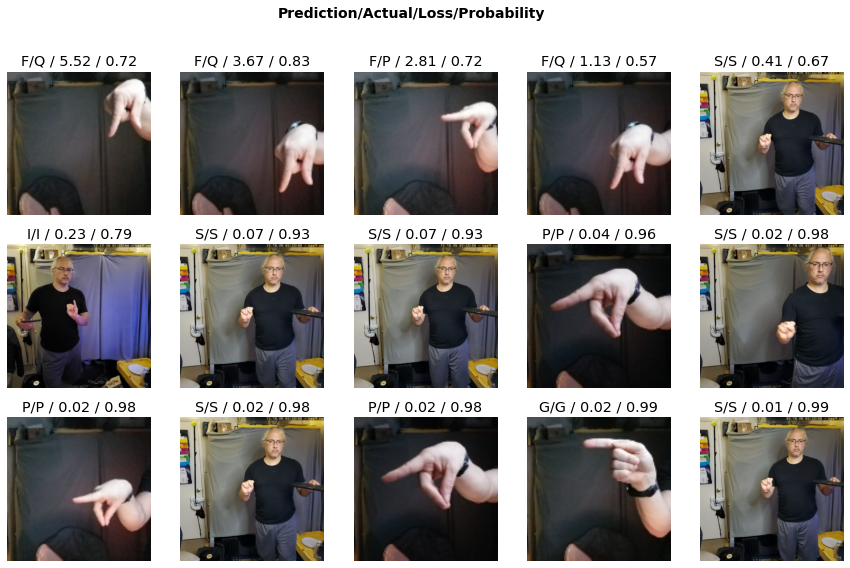

In [11]:
interp.plot_top_losses(15, nrows=3)

<br>

### Clean the images that were hard to interpret and obviously bad

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

<br>
<br>
<hr>
<br>
<br>

## Persist the Model



In [8]:
learn.export('../models/200925-1745-RESNET101-384px-FONLY-ft3f3.pkl')
path = Path('../models')
path.ls(file_exts='.pkl')

(#13) [Path('../models/export-resnet101-FALL-tune2ft-tune10un-tune2ft.pkl'),Path('../models/200924-0600-RESNET101-300px-FALL-ft6f3.pkl'),Path('../models/export-resnet101-F-tune2ft-tune10un-tune2ft.pkl'),Path('../models/200923-2300-MOBILENET2-FALL-ft6f3.pkl'),Path('../models/200924-0600-RESNET100-300px-FALL-ft6f3.pkl'),Path('../models/200924-1515-RESNET101-384px-FALL-ft6f3.pkl'),Path('../models/200924-1515-RESNET101-384px-FONLY-ft6f4.pkl'),Path('../models/export-resnet101-tune10un-tune2ft.pkl'),Path('../models/200923-2300-MOBILENET2-PYTORCHONLY-FALL-ft6f3.pkl'),Path('../models/200921-0235-RN101-ALL-ut10-f2ft-F-f2ft.pkl')...]

In [ ]:
# %cd ..
# learn_inf.save('save/200921-0201-export-resnet101-FALL-tune2ft-tune6un-tune2ft-F-t2ft-ut3-t2ft-t2ft')
# %cd notebooks

<br>
<br>
<br>
<hr>
<br>

# Log

* started to plot the learning rates and started to use that information while fitting.
* Downgraded to resnet34 @ 300px in order to increase the resolution fed to the model from 128px to 300px - this made a major difference.
* Decreased the number of training epochs to 6 after experimenting to find the sweet spot. - also positive change
* Changed to exclusively use fine-tune() with it's built in freeze_epochs parameter
* Changed the Batch Size in order to bring the arch back to resnet101 @300px
* Cleaned up the markdown, removed cells and reordered the rest.

** Attempting a batch size of 12 and 384px with resnet101.  long training times.
** Also increased the epochs to 4 on the final layer and 7 on the rest.
    